In [1]:
import json_lines
from langdetect import detect
from langdetect import detect_langs
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.neural_network import MLPClassifier
import numpy as np

from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

lemmatizer = WordNetLemmatizer()
REMOVEABLE_CHARS = "»<>123456789\/&()?:!.,;'´"
ALL_TAGS = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT',
 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
 'WP$', 'WRB']
ACCEPTABLE_TAGS = ['CC', 'DT', 'EX', 'FW', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'PDT',
 'POS', 'PRP', 'PRP$', 'RP', 'TO', 'UH', 'VBD', 'VBG', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
MAX_FEATURES = 300
MIN_ENGLISH = 0.9999
LIMIT_INPUT_ROWS = 5000 # to stop run times hindering development (making this < 500 usually makes the graph angry)

def get_wordnet_pos(tag): # Return a char, based on input tag, that is used as a param in lemmatisation for enhanced results
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [2]:
# READ IN INFO
reviews= []; polarity= []; are_early= [];
with open ('reviews.json', 'rb') as f:
    for i, item in enumerate(json_lines.reader(f)):
        if i <= LIMIT_INPUT_ROWS:
            try:
                langs = detect_langs(item['text'])
            except:
                pass
            for i, lang in enumerate(langs):
                if str(lang)[0:2] == 'en':
                    if float(str(lang)[3:]) > MIN_ENGLISH:
                        reviews.append(item['text'])
                        polarity.append(item['voted_up'])
                        are_early.append(item['early_access'])

In [3]:
# FILTER TEXT
for i, text in enumerate(reviews):
    text_words = nltk.word_tokenize(text.lower())
    tags = nltk.pos_tag(text_words)
    #print(tags)
    new_text= [];
    for j, word in enumerate(text_words):
        for char in word:
            if char in REMOVEABLE_CHARS:
                break
        else:
            wordnet_pos = get_wordnet_pos(tags[j][1])
            if wordnet_pos != '':
                new_text.append(lemmatizer.lemmatize(word, wordnet_pos))
            continue
    reviews[i] = new_text

for i, text in enumerate(reviews): 
    new_text= [];
    tags = nltk.pos_tag(reviews[i])
    for j, word in enumerate(text):
        if tags[j][1] in ACCEPTABLE_TAGS:
            new_text.append(word)
    reviews[i] = new_text
    #print(tags)

In [4]:
# MOST FREQ WORDS AS FEATURES
word_counts = {};
for text in reviews:
    for word in text:
        if word in word_counts:
            word_counts[word]+= 1
        else:
            word_counts[word]= 1
word_counts = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}
trimd_word_counts = {}
if len(word_counts) > MAX_FEATURES:
    for i, entry in enumerate(word_counts):
        if i >= MAX_FEATURES:
            break
        trimd_word_counts[entry] = word_counts[entry]
word_counts = trimd_word_counts

tags = nltk.pos_tag(word_counts.keys()); # this part is just for the below print statement
for i, word in enumerate(word_counts):
    print("word: ", word, "| tag: ", tags[i][1], "| count: ",word_counts[word],"\n")

word:  i | tag:  RB | count:  883 

word:  good | tag:  JJ | count:  512 

word:  bad | tag:  JJ | count:  253 

word:  great | tag:  JJ | count:  244 

word:  other | tag:  JJ | count:  239 

word:  new | tag:  JJ | count:  220 

word:  much | tag:  JJ | count:  208 

word:  up | tag:  IN | count:  202 

word:  more | tag:  JJR | count:  179 

word:  out | tag:  IN | count:  167 

word:  many | tag:  JJ | count:  159 

word:  best | tag:  JJS | count:  145 

word:  same | tag:  JJ | count:  137 

word:  graphic | tag:  JJ | count:  128 

word:  hard | tag:  JJ | count:  124 

word:  free | tag:  JJ | count:  123 

word:  fun | tag:  NN | count:  119 

word:  few | tag:  JJ | count:  117 

word:  first | tag:  JJ | count:  116 

word:  nice | tag:  RB | count:  109 

word:  big | tag:  JJ | count:  104 

word:  different | tag:  JJ | count:  94 

word:  old | tag:  JJ | count:  86 

word:  full | tag:  JJ | count:  86 

word:  last | tag:  JJ | count:  83 

word:  little | tag:  JJ | c

word:  developer | tag:  NN | count:  13 

word:  matchmaking | tag:  VBG | count:  13 

word:  shoot | tag:  NN | count:  12 

word:  obvious | tag:  JJ | count:  12 

word:  absolute | tag:  NN | count:  12 

word:  solid | tag:  VBD | count:  12 

word:  multiplayer | tag:  JJ | count:  12 

word:  half | tag:  NN | count:  12 

word:  bring | tag:  NN | count:  12 

word:  survive | tag:  JJ | count:  12 

word:  ur | tag:  JJ | count:  12 

word:  creative | tag:  JJ | count:  12 

word:  let | tag:  NN | count:  12 

word:  third | tag:  JJ | count:  12 

word:  okay | tag:  JJ | count:  12 

word:  female | tag:  NN | count:  12 

word:  important | tag:  JJ | count:  12 

word:  multiple | tag:  JJ | count:  12 

word:  dumb | tag:  JJ | count:  12 

word:  read | tag:  NN | count:  12 

word:  alive | tag:  JJ | count:  12 

word:  f | tag:  NN | count:  12 

word:  type | tag:  NN | count:  12 

word:  trash | tag:  NN | count:  12 

word:  buggy | tag:  NN | count:  11 

wor

In [5]:
# CREATE 1-HOT ENCODINGS
one_hots = [];
for text in reviews:
    one_hot = [];
    for i in range(MAX_FEATURES):
        one_hot.append(0)
    for word in text:
        if word in word_counts:
            one_hot[list(word_counts).index(word)]+= 1
    one_hots.append(one_hot)

for i, one_hot in enumerate(one_hots): # convert array of lists into 2d array
    one_hot_arr = np.array(one_hot)
    one_hots[i] = one_hot_arr
one_hots = np.array(one_hots)

overall accuracy:  0.6507936507936508


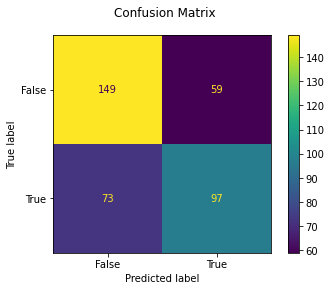

In [6]:
# TRAIN, PREDICT, GRAPH
X_train, X_test, y_train, y_test = train_test_split(one_hots, polarity, random_state=1, test_size=0.2) # change the second param here to switch between polarity and early_access
sc_X = StandardScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_test_scaled = sc_X.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32), activation="relu", random_state=1).fit(X_train_scaled, y_train)
y_pred=clf.predict(X_test_scaled)
print("overall accuracy: ",clf.score(X_test_scaled, y_test))

fig=plot_confusion_matrix(clf, X_test_scaled, y_test)
fig.figure_.suptitle("Confusion Matrix")
plt.show()